<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Creating-tables" data-toc-modified-id="Creating-tables-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Creating tables</a></span><ul class="toc-item"><li><span><a href="#Data-types-settings" data-toc-modified-id="Data-types-settings-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data types settings</a></span></li><li><span><a href="#Loading-the-data-into-the-Postgres-table" data-toc-modified-id="Loading-the-data-into-the-Postgres-table-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Loading the data into the Postgres table</a></span></li></ul></li><li><span><a href="#Setting-users-privileges" data-toc-modified-id="Setting-users-privileges-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Setting users privileges</a></span><ul class="toc-item"><li><span><a href="#The-least-privilege-principle" data-toc-modified-id="The-least-privilege-principle-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>The least privilege principle</a></span></li><li><span><a href="#Testing-the-results" data-toc-modified-id="Testing-the-results-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Testing the results</a></span></li></ul></li><li><span><a href="#Exploratory-Data-Analysis-(EDA)" data-toc-modified-id="Exploratory-Data-Analysis-(EDA)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Exploratory Data Analysis (EDA)</a></span><ul class="toc-item"><li><span><a href="#Loading-the-data-into-a-pandas-DataFrame" data-toc-modified-id="Loading-the-data-into-a-pandas-DataFrame-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Loading the data into a pandas DataFrame</a></span></li><li><span><a href="#Quick-overview-with-raw-daily-data" data-toc-modified-id="Quick-overview-with-raw-daily-data-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Quick overview with raw daily data</a></span></li><li><span><a href="#Zooming-on-UCR-Part-I-offenses" data-toc-modified-id="Zooming-on-UCR-Part-I-offenses-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Zooming on UCR Part I offenses</a></span></li><li><span><a href="#Extracting-crime-trends-and-seasonality-with-Singular-Spectrum-Analysis-(SSA)" data-toc-modified-id="Extracting-crime-trends-and-seasonality-with-Singular-Spectrum-Analysis-(SSA)-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Extracting crime trends and seasonality with Singular Spectrum Analysis (SSA)</a></span><ul class="toc-item"><li><span><a href="#Decomposition" data-toc-modified-id="Decomposition-4.4.1"><span class="toc-item-num">4.4.1&nbsp;&nbsp;</span>Decomposition</a></span><ul class="toc-item"><li><span><a href="#The-trajectory-matrix" data-toc-modified-id="The-trajectory-matrix-4.4.1.1"><span class="toc-item-num">4.4.1.1&nbsp;&nbsp;</span>The trajectory matrix</a></span></li><li><span><a href="#Singular-value-decompositon-(SVD)" data-toc-modified-id="Singular-value-decompositon-(SVD)-4.4.1.2"><span class="toc-item-num">4.4.1.2&nbsp;&nbsp;</span>Singular value decompositon (SVD)</a></span></li><li><span><a href="#The-elementary-matrices" data-toc-modified-id="The-elementary-matrices-4.4.1.3"><span class="toc-item-num">4.4.1.3&nbsp;&nbsp;</span>The elementary matrices</a></span></li><li><span><a href="#Diagonal-averaging" data-toc-modified-id="Diagonal-averaging-4.4.1.4"><span class="toc-item-num">4.4.1.4&nbsp;&nbsp;</span>Diagonal averaging</a></span></li></ul></li><li><span><a href="#Plotting-the-components" data-toc-modified-id="Plotting-the-components-4.4.2"><span class="toc-item-num">4.4.2&nbsp;&nbsp;</span>Plotting the components</a></span></li></ul></li></ul></li></ul></div>

# How to build a Postgres database
## Introduction

In this guided project, we will put everything together to build a database for storing data related with crimes that occurred in Boston. The cleaned dataset provided by [Dataquest](https://www.dataquest.io/) is available in the file <code>boston.csv</code>.

The data we will work with is known as *Crime Incident Reports*. It's published under PDDL license by [Analyse Boston](https://data.boston.gov/). 

Crime incident reports are provided by Boston Police Department (BPD) to document the initial details surrounding an incident to which BPD officers respond. This is a dataset containing records from the new crime incident report system, which includes a reduced set of fields focused on capturing the type of incident as well as when and where it occurred. Records in the new system begin in June of 2015.

More information and up-to-date Crime Incident Reports dataset can be found at: https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

import psycopg2
import csv

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#header and first four rows
pd.read_csv('boston.csv')[0:5]

The first column represents the identifier of the crime. The second contains a numeric identifier code for the committed crime. The third represents a description of the crime. The next two rows contain the date on which the crime happened and the corresponding day of the week. Finally, the last two columns represent the location of the crime with a latitude and longitude coordinates.


We will create a database named <code>crimes_db</code> with a table – <code>boston_crimes</code> – with appropriate data types for storing the data. Then we will be creating the table inside a [schema](https://www.postgresql.org/docs/9.1/ddl-schemas.html) named <code>crimes</code>. We will also create the readonly and readwrite groups with the appropriate [privileges](https://www.postgresql.org/docs/9.1/ddl-priv.html). Finally, we will also need to create one user for each of these groups.

In [ ]:
#connexion to the Dataquest database with user dq and new database creation
conn = psycopg2.connect("dbname=dq user=dq")
conn.autocommit = True
cur = conn.cursor()
cur.execute("""CREATE DATABASE crime_db;""")
conn.autocommit = False #can we delete this line as we close the connexion just after?
conn.close()

In [ ]:
#connexion to the new database and schema creation
conn = psycopg2.connect("dbname=crime_db user=dq")
conn.autocommit = True
cur = conn.cursor()
cur.execute("""CREATE SCHEMA crimes;""")
conn.autocommit = False

Before we start creating tables, let's gather some data about our crime dataset so that we can more easily select the right data types to use in our tables.

In [ ]:
#reading the CSV file by using the csv module as follows:
rows=list()
with open('boston.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        rows.append(row)
col_headers = rows[0]
first_row = rows[1]

In [ ]:
print(col_headers)

In [ ]:
print(first_row)

We now have the column names as well as the first row values at hand throughout this guided project so that we can easily take a look at them at any moment.

## Creating tables
### Data types settings

Before starting, you may find useful to check the Postgres documentation for the following data types:
* [Numeric Types](https://www.postgresql.org/docs/9.2/datatype-numeric.html)
* [Character Types](https://www.postgresql.org/docs/9.2/datatype-character.html)
* [Date/Time Types](https://www.postgresql.org/docs/9.2/datatype-datetime.html)
* [Enumerated Types](https://www.postgresql.org/docs/9.2/datatype-enum.html)

We need to identify the proper data types for the columns. To help us with that, we will create a function — <code>get_col_value_set()</code> —  that given the name of a CSV file and a column index (starting at zero) computes a Python set with all distinct values contained in that column.
This function will be useful for two reasons:
* Checking whether an <code>enumerated</code> type might be a good choice for representing a column.
* Computing the maximum length of any text-like column to select appropriate sizes for <code>varchar</code> columns.

In [ ]:
def get_col_value_set(csv_filename, col_index):
    with open(csv_filename, 'r') as f:
        next(f) # skip the row containing column headers
        reader = csv.reader(f)
        # create a set to contain all distinct values contained in that column
        unique_values_in_column = set()
        for row in reader:
            # add the column values from this row to the set
            column_values = row[col_index]
            unique_values_in_column.add(column_values)
        return unique_values_in_column

In [ ]:
#computing with a for loop the number of unique values each column contains.
for i in range(0,7):
    print(col_headers[i],len(get_col_value_set('boston.csv', i)))

Columns with a low number of distinct values tend to be good candidates for enumerated types.
Another important aspect is to know the longest word in any column containing textual data. We can actually use the previous function for computing this.


There are two textual column in the dataset, namely, the <code>description</code> and <code>day_of_the_week</code> columns. However the day of the week contains only $7$ different values, one for each day. We can tell that the longest of them is *Wednesday* without needing any computation.
Let's compute the maximum length for the values contained in the description column.

In [ ]:
#description column index = 2
description_values = get_col_value_set('boston.csv', 2)
max_length = 0
for row in description_values:
    if len(row) > max_length:
        max_length = len(row)
print(max_length)

However, according to Analyse Boston (see [Crime Incident Field Explanation](https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system/resource/9c30453a-fefa-4fe0-b51a-5fc09b0f4655)), the appropriate varchar length for this text field is $80$, so we will use this number when creating the table, as in the future we may want to update our database and new offense descriptions could arise.

Before examining the numerical columns, let's prepare the enumerated type query string for the weekday column. We will execute the query later.

In [ ]:
create_type_string = """CREATE TYPE day_of_the_week_enum AS ENUM
    ('Sunday',
     'Monday',
     'Tuesday',
     'Wednesday',
     'Thursday',
     'Friday',
     'Saturday');"""

The column <code>incident_number</code> is an autoincrementing integer one. Since its maximum value ($=298329$) is only a $4$ bytes number, we will use the <code>serial</code> type.

Let`s retrieve the maximum value and the maximum length for the values contained in the second column <code>offense_code</code>.

In [ ]:
offense_code_values = get_col_value_set('boston.csv', 1)
max_length = 0
max_value = 0 
for row in offense_code_values:
    if len(row) > max_length:
        max_length = len(row)
    if int(row) > max_value:
        max_value = int(row)
print(max_length, max_value)

Sometimes, the right data type for a given column may be a <code>character</code> type even if the values look like a number (as for postal codes for example). Here is one simple reason: you cannot perform arithmetic on them. In addition, leading zeros are important.
In a SQL database, this would typically be <code>varchar</code> or <code>char</code>, of the appropriate length.


The fourth column contains the date when occurred the event, so we will use the <code>date</code> type which is used to represent a specific day of the year. The storage size fort this data type is $4$ bytes.

Now let's examine the latitude and the longitude columns: they contains decimal numbers. With the Postgres <code>decimal</code> type, we can set our own precision and scale of the number which means we can choose how many bytes our entries will require.
* The *precision* gives the maximum number of digits in total (before and after the decimal point). 
* The *scale* specifies the maximum amount of digits after the decimal point.

As we already know the valid range in degrees for latitude ($-90°$ and $+90°$) as for longitude ($-180°$ and $+180°$), we just need to calculate the maximum scale contained in <code>lat</code> and <code>long</code> columns and then add $2$ for the latitude precision and $3$ for the longitude precision. By this way, our table will be correctly set in case of reuse with other location than Boston in the future.

So we will create a function that computes the maximum scale for a given set of column values.

In [ ]:
def get_scale(col_value_set):    
    max_scale = 0
    for row in col_value_set:        
        scale = 0
        for idx, r in enumerate(row):            
            if r == ".":
                scale = len(row)- idx - 1        
        if scale > max_scale:
            max_scale = scale
    return(max_scale)

In [ ]:
lat_values = get_col_value_set('boston.csv', 5)
long_values =  get_col_value_set('boston.csv', 6)
lat_max_scale = get_scale(lat_values)
long_max_scale = get_scale(long_values)
print(lat_max_scale, long_max_scale)

We now can create our table <code>boston_crimes</code> inside the <code>crimes</code> schema with the appropriate data type for each column.


In [ ]:
#executing the enumerated type query string
cur.execute(create_type_string)
#table creation query string
create_string = """CREATE TABLE crimes.boston_crimes (
    incident_number serial PRIMARY KEY,
    offense_code varchar(4),
    description varchar(80),
    date date,
    day_of_the_week day_of_the_week_enum,
    lat decimal(10,8),
    long decimal(11,8)
 );
 """
#executing the table creation query string
cur.execute(create_string)
#commit the transaction
conn.commit()
#checking the result
cur.execute("SELECT * FROM crimes.boston_crimes LIMIT 0;")
cur.description

### Loading the data into the Postgres table

Now that we have created the table, we can load the data into it. We will use the [cursor.copy_expert() method](https://www.psycopg.org/docs/cursor.html#cursor.copy_expert).

In [ ]:
with open("boston.csv") as f:
    cur.copy_expert("COPY crimes.boston_crimes FROM STDIN WITH CSV HEADER;", f)
conn.commit()
#checking the result printing the first five rows
cur.execute("SELECT * FROM crimes.boston_crimes LIMIT 5;")
cur.fetchall()

## Setting users privileges
### The least privilege principle

By following the [least privilege principle](https://en.wikipedia.org/wiki/Principle_of_least_privilege), the first step in doing so is to make sure that there are no privileges inherited from the <code>public</code> group and on the <code>public</code> schema. 

In [ ]:
cur.execute("""REVOKE ALL ON SCHEMA public FROM public;""")
cur.execute("""REVOKE ALL ON DATABASE crime_db FROM public;""")
conn.commit()

A *readonly* group is defined as a users group who has no other privileges except for being able to read data from your database. This is likely the type of users profile that we would set up for **data analysts** as, in general, such users need only to be able to access the data for analysis. So we will only grant <code>SELECT</code> privileges for the readonly group.

Another common group is the *readwrite* group which has privileges to read, insert and remove data from tables but cannot drop tables. In a similar way, you can think of the readwrite to be a suitable group for **data scientists**. Those users need to be able to analyze the data but they are also responsible for collecting, cleaning the data and loading it into the database.
Following the least privilege principle, it seems that a suitable set of privileges for these kinds of users consist of the <code>SELECT</code>, <code>INSERT</code>, <code>UPDATE</code> and <code>DELETE</code> commands.

The <code>DROP</code> commands that is used to remove a table is not usually granted as it is more of a **data engineer** role to setup the platform and deal with table creation as with data types settings.

These roles are of course not mutually exclusive and can share common tasks.
However these user groups are quite common as you can read in this [blog post]( https://aws.amazon.com/es/blogs/database/managing-postgresql-users-and-roles/).

It's also a good practice to always make sure that groups cannot be used for login. We can do that using the <code>NOLOGIN</code> option when creating the group.

In [ ]:
#create two groups named readonly and readwrite with the no NOLOGIN option.
cur.execute("""CREATE GROUP readonly NOLOGIN;""")
cur.execute("""CREATE GROUP readwrite NOLOGIN;""")
#the two groups need connection privileges, otherwise they won't be able to do anything
cur.execute("""GRANT CONNECT ON DATABASE crime_db TO readonly;""")
cur.execute("""GRANT CONNECT ON DATABASE crime_db TO readwrite;""")
#they also need usage privileges for the crimes schema
cur.execute("""GRANT USAGE ON SCHEMA crimes TO readonly;""")
cur.execute("""GRANT USAGE ON SCHEMA crimes TO readwrite;""")
#setting specific privileges to each group for all tables in crimes schema
cur.execute("""GRANT SELECT ON ALL TABLES IN SCHEMA crimes TO readonly;""")
cur.execute("""GRANT SELECT, INSERT, DELETE, UPDATE ON ALL TABLES IN SCHEMA crimes TO readwrite;""")

conn.commit()

Last step, we will create one user with password for each group.

In [ ]:
cur.execute("""CREATE USER data_analyst WITH PASSWORD 'secret1';""")
cur.execute("""GRANT data_analyst TO readonly;""")
cur.execute("""CREATE USER data_scientist WITH PASSWORD 'secret2';""")
cur.execute("""GRANT data_scientist TO readwrite;""")

conn.commit()

### Testing the results

It is a good practice to test that everything is configured as expected when you finish setting up the database. 
We can use SQL queries to check whether the objects have been created and that users and groups have the right privileges. This requires you to know the Postgres internal tables. We can query the [pg_roles table](https://www.postgresql.org/docs/10/view-pg-roles.html) to inspect privileges related to the database and the [information_schema.table_privileges table](https://www.postgresql.org/docs/9.1/infoschema-table-privileges.html) to inspect table privileges.

In [ ]:
test_string = """SELECT grantee, privilege_type
    FROM information_schema.table_privileges
    WHERE grantee = 'readwrite';"""
cur.execute(test_string)
cur.fetchall()

In [ ]:
test_string = """SELECT grantee, privilege_type
    FROM information_schema.table_privileges
    WHERE grantee = 'readonly';"""
cur.execute(test_string)
cur.fetchall()

In [ ]:
test_string = """SELECT rolsuper, rolcanlogin, rolcreaterole, rolcreatedb
    FROM pg_roles
    WHERE rolname = 'readonly';"""
cur.execute(test_string)
cur.fetchall()

In [ ]:
test_string = """SELECT rolsuper, rolcanlogin, rolcreaterole, rolcreatedb
    FROM pg_roles
    WHERE rolname = 'readwrite';"""
cur.execute(test_string)
cur.fetchall()

In [ ]:
test_string = """SELECT rolsuper, rolcanlogin, rolcreaterole, rolcreatedb, rolpassword
    FROM pg_roles
    WHERE rolname = 'data_analyst';"""
cur.execute(test_string)
cur.fetchall()

In [ ]:
test_string = """SELECT rolsuper, rolcanlogin, rolcreaterole, rolcreatedb, rolpassword
    FROM pg_roles
    WHERE rolname = 'data_scientist';"""
cur.execute(test_string)
cur.fetchall()

In [ ]:
test_string = """SELECT rolsuper, rolcanlogin, rolcreaterole, rolcreatedb, rolpassword
    FROM pg_roles
    WHERE rolname = 'dq';"""
cur.execute(test_string)
cur.fetchall()

After <code>cheking pg_roles</code> and <code>information_schema.table_privileges</code> tables, it appears that:
* Table privileges are correctly granted for each group.
* Database privileges have been correctly limited for each group.

In [ ]:
#closing the connection
conn.close()

## Exploratory Data Analysis (EDA)

A lot of EDA have already been done based on Crime Incident Reports dataset. See the links below:
1. [Kaggle](https://www.kaggle.com/AnalyzeBoston/crimes-in-boston/notebooks) (a list of 127 inspiring notebooks)
2. [Pankaj Shah](https://rstudio-pubs-static.s3.amazonaws.com/453629_6be32e64d25b4e7189bc3bbe6968bcaf.html) (done with R)

We have also identified two projects using Crime Incident Reports dataset combined with other data:
1. [Trash City](https://jhaddadin.github.io/trashcity/)
2. [Imagine Boston](https://analytics.boston.gov/app/imagine-boston)

This few examples show us how we can use data to promote civic engagement, explore possible correlations, create data-driven stories, set-up map landmark locations, etc. 

<s>Let's perform in first some basic stuff.</s>

### Loading the data into a pandas DataFrame

In [ ]:
#connection to database with data_analyst user
conn = psycopg2.connect("dbname=crime_db user=dq")
cur = conn.cursor()

query = """SELECT * FROM crimes.boston_crimes"""

# Create a pandas dataframe from the SQL query with sorted datetime index
data = pd.read_sql(query, con=conn,index_col="date").sort_index()

In [2]:
#data=pd.read_csv("data/csv/01_Boston-Crime-Report_2020-09-28.csv", index_col = "OCCURRED_ON_DATE").sort_index()
data=pd.read_csv("data/csv/boston.csv", index_col = "date").sort_index()

In [ ]:
#data["INCIDENT_NUMBER"].value_counts()
#data[data["INCIDENT_NUMBER"]=="I152071596"]

In [14]:
#data["incident_number"].value_counts()

2047     1
98917    1
90745    1
96890    1
94843    1
        ..
11695    1
54704    1
56753    1
50610    1
2049     1
Name: incident_number, Length: 298329, dtype: int64

In [96]:
from IPython.core.display import HTML
import json
def css_styling():
    styles = open("custom.css", "r").read() #or edit path to custom.css
    return HTML(styles)
css_styling()


In [4]:
#printing first rows
data.head(5)

,incident_number,offense_code,description,day_of_the_week,lat,long
date,,,,,,
2015-06-15,297827,3208,PROPERTY - MISSING,Monday,42.379073,-71.033867
2015-06-15,297905,1874,DRUGS - OTHER,Monday,42.310434,-71.061340
2015-06-15,297906,724,AUTO THEFT,Monday,42.302422,-71.061229
2015-06-15,297907,3114,INVESTIGATE PROPERTY,Monday,42.326903,-71.086401
2015-06-15,297908,3301,VERBAL DISPUTE,Monday,42.341466,-71.090828


In [5]:
#check if missing values
print(data.isnull().sum())

incident_number    0
offense_code       0
description        0
day_of_the_week    0
lat                0
long               0
dtype: int64


In [6]:
#check if duplicated values
data.duplicated().sum()

0

In [7]:
#check data types
data.dtypes

incident_number      int64
offense_code         int64
description         object
day_of_the_week     object
lat                float64
long               float64
dtype: object

In [8]:
print(data.index.dtype)
#We need to set a proper datetime data type
data.index = pd.to_datetime(data.index)
print(data.index.dtype)

object
datetime64[ns]


In [9]:
print("Start at: " + str(data.index[0]))
print("End at: " + str(data.index[-1]))
print("Number of days: " + str(len(data.index.value_counts())))

Start at: 2015-06-15 00:00:00
End at: 2018-09-03 00:00:00
Number of days: 1177


### Quick overview with raw daily data 

In [45]:
#daily aggregate
daily = data.index.value_counts(sort=False).sort_index()

daily.describe()

count    1177.000000
mean      253.465590
std        30.645588
min       134.000000
25%       235.000000
50%       255.000000
75%       274.000000
max       354.000000
Name: date, dtype: float64

In [46]:
#define some useful lists
daily_index=daily.index
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']  
weekdays = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

In [49]:
#prevent from warnings 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

<a id='fig1'></a>

<a id='fig1'></a>

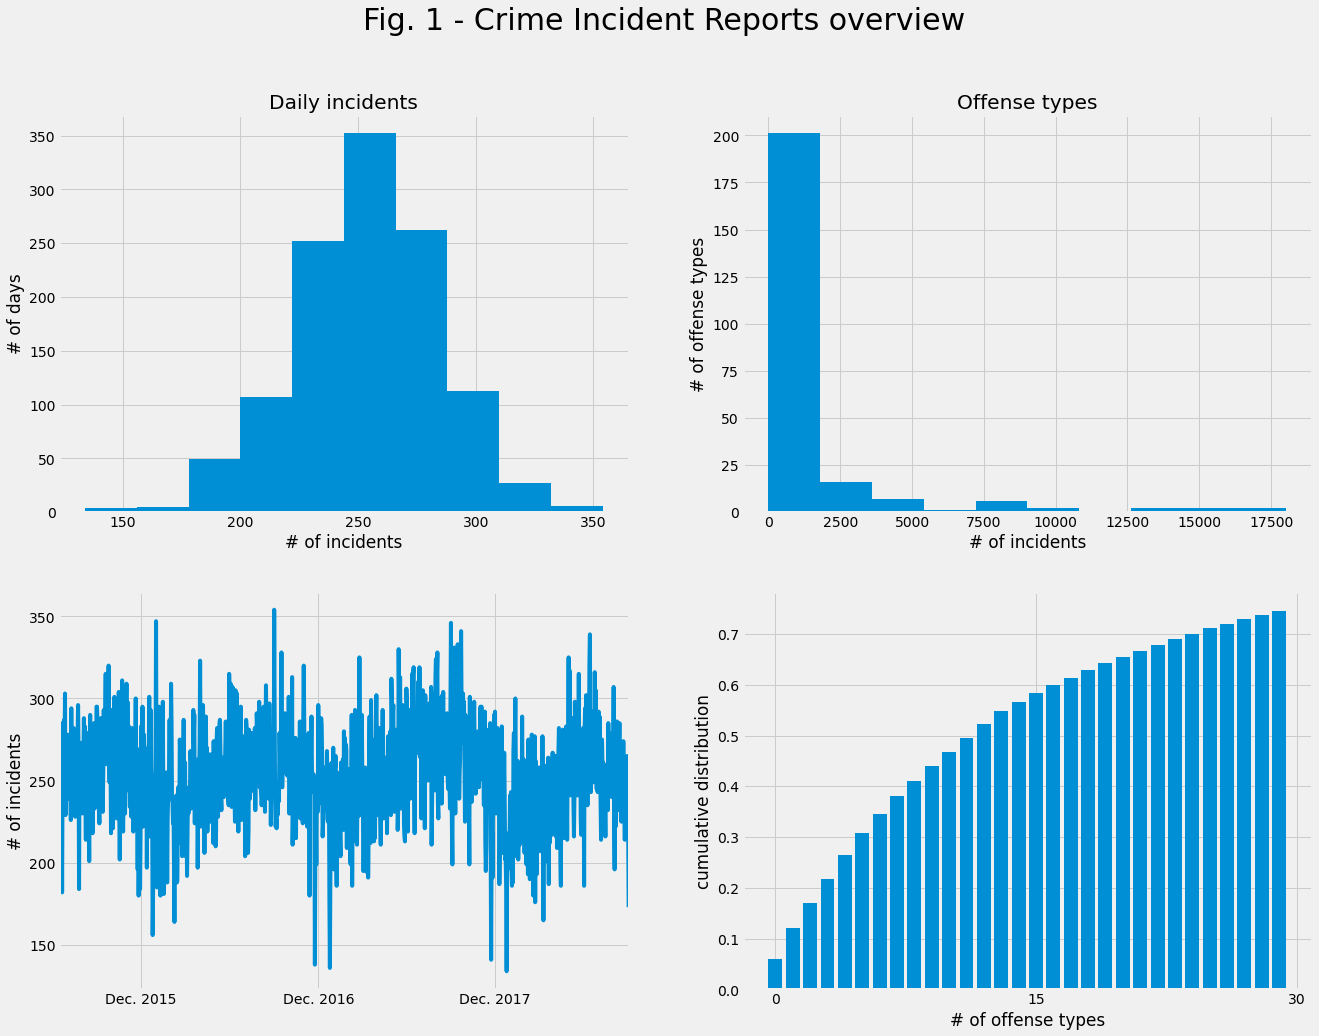

In [23]:
import matplotlib.dates as mdates
locator = mdates.MonthLocator(12)
fmt = mdates.DateFormatter('%b. %Y')

#plotting daily report
#fig = plt.figure(figsize=(10, 5))
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(2,2, figsize=(20, 15))

fig.suptitle("Fig. 1 - Crime Incident Reports overview", fontsize="30")
ax[0,0].hist(daily)
ax[0,0].set_title("Daily incidents")
ax[0,0].set_xlabel("# of incidents")
ax[0,0].set_ylabel("# of days")


ax[1,0].xaxis.set_major_locator(locator)
ax[1,0].xaxis.set_major_formatter(fmt)
ax[1,0].set_xlim(daily.index[0],daily.index[-1])
ax[1,0].plot(daily.index,daily)
ax[1,0].set_ylabel("# of incidents")
#ax[1,0].set_title("Daily aggregate")

ax[0,1].hist(data["description"].value_counts())
ax[0,1].set_xlabel("# of incidents")
ax[0,1].set_ylabel("# of offense types")
ax[0,1].set_title("Offense types")

cdf = data["description"].value_counts(ascending=False).cumsum()[:30]/np.sum(data["description"].value_counts())
ax[1,1].bar(range(30),cdf)
ax[1,1].set_xlabel("# of offense types")
ax[1,1].set_xticks(range(0,45,15))
ax[1,1].set_ylabel("cumulative distribution")
#ax[1,1].set_title("Top-30")

plt.show()

**Fig. 1. - Crime Incident Reports overview.** While the total number of incidents in Boston rarely exceeds 350 events on a single day, following what looks like a perfect Gaussian distribution, the raw daily data is obscured by seasonal oscillations and a certain amount of stochasticity. Also, the long term trend doesn't show any clear direction. On the other hand, the offense types distribution is very unbalanced showing a large fat tail typical of a [Pareto distribution](https://en.wikipedia.org/wiki/Pareto_distribution). As a matter of fact, 12,5% (30/229) of offense types account for 74,6% of the incidents, which is very close to the [80/20 rule](https://en.wikipedia.org/wiki/Pareto_principle). Therefore, if we want to evaluate correctly the success -or the failure- of the public safety policy at Boston, it's better to focus on the most relevant offense categories. This is how we will proceed in the next sections.

In [99]:
#remove the comment below if you want to print the top 30 offense types
#print(data["description"].value_counts(ascending=False)[:30])

In [104]:
%%html
<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Pareto (work on the 20% that brings the 80%) is not only about prioritization.<br><br>It’s also about avoiding working on spurious coincidences - the noise that caused that small correlation which won’t repeat.</p>&mdash; Luca-Dellanna.com (@DellAnnaLuca) <a href="https://twitter.com/DellAnnaLuca/status/1311671141816242177?ref_src=twsrc%5Etfw">October 1, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>

An heatmap is a useful visualization technique to show in two dimensions the magnitude of a phenomenom with color variations. Since the [Fig. 1](#fig1) gives some *clues* of seasonality we want to investigate, by reorganizing our daily time series into a 2d-array - x-axis for weekdays, y-axis for months-, the seasonal pattern if present should become evident once generated the appropriate heatmap.

In [11]:
def getHeatmapArray(df): #rename function?
    """
    input: a time series DataFrame
    output: a numpy array with shape(7,12) which x-axis = weekday and y-axis = month
    """
    ar = np.zeros(shape=(7,12),dtype=np.float32)
    for i in range(len(df)):        
        d=df.index[i].weekday() 
        m=df.index[i].month
        ar[d][m-1]+=1
    return ar

<a id='fig2'></a>

In [ ]:
<a id='fig2'></a>

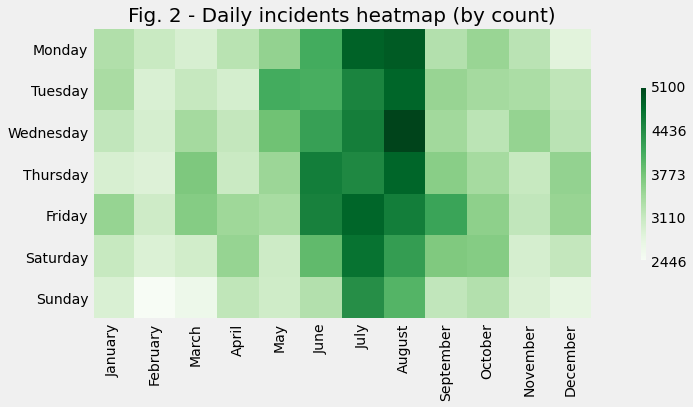

In [16]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(1,1, figsize=(15,5))

plt.yticks(range(7), weekdays)
plt.xticks(range(12), months, rotation='vertical')
d = getHeatmapArray(data)
img = ax.imshow(d,plt.cm.Greens,interpolation='nearest')
ax.grid(False)
ax.set_title("Fig. 2 - Daily incidents heatmap (by count)",fontsize=20)
bins = np.linspace(d.min(), d.max(), 5)
plt.colorbar(img, shrink=.6, ticks=bins)
plt.show()

<span class="caption"><strong>Fig. 2. - Daily incidents heatmap (by count).</strong> Peak in summer looks obvious from the figure above, although we prefer to be careful and think it twice before drawing conclusions too quickly from charts. However, these figures are also a very good food for thought. They help us a lot to navigate through the noisy data we are trying to understand better. So we will say this is a good start for us and be open to future unexpected discoveries.

Seasonality is a classic pattern in criminology though still without being well understood by academics. The subject has been studied for over a century (first by [Quetelet](https://books.google.es/books?id=KqNeqw8YyxQC&redir_esc=y), who was obsessed by finding a clear correlation with temperature variations). So this is not very surprising whether summer appears to be the hot crime season in Boston. But, as said before, now we need to examine the dataset by offense categories if we want to learn more about this phenomenon arousing our curiosity -and about crime in general.

### Zooming on UCR Part I offenses


Since we are interested in learning more about seasonality and its potential consequences, we will know narrow our data following the [Uniform Crime Reporting (UCR)](https://ucr.fbi.gov/crime-in-the-u.s/2010/crime-in-the-u.s.-2010/offense-definitions) system from the FBI.

> The Uniform Crime Reporting (UCR) Program divides offenses into two groups, Part I and Part II crimes. [...] Contributors provide *only arrest* data for Part II offenses. [...] The UCR Program collects data about Part I offenses in order to measure the level and scope of crime occurring throughout the Nation. The program's founders chose these offenses because they are serious crimes, they occur with regularity in all areas of the country, and they are *likely* to be reported to police. [*Italics added by us.*]

Note that Part II offenses are arrests only, so the true number of offenses is likely to be sligthly underestimated. This is not the case for Part I crimes since arrests as well as reported incidents without arrest are collected. Unfortunatly, rape crimes are not contained in our dataset.


The Part I crimes are divided in two categories: violent crimes (crime against persons) and property crimes (crime against property).


|    Violent Crimes    	| Property Crimes 	|
|:---------------------:|:-----------------:|
| ASSAULT - AGGRAVATED 	|     LARCENY     	|
|        MURDER        	|    AUTO THEFT   	|
|        ROBBERY       	|      ARSON      	|
|         RAPE         	|     BURGLARY    	|

In [29]:
# keywords_dict = {"Violent Crimes": ["ASSAULT - AGGRAVATED","MURDER","ROBBERY","RAPE"],
#             "Property Crimes": ["LARCENY","AUTO THEFT","ARSON","BURGLARY"]}
# ucr_part_one_df = pd.DataFrame(keywords_dict)
# # ucr_part_one_df

In [32]:
def offenseExtractor(df, _name):
    """
    inputs:
        df: a dataframe
        _name : a string or a regular expression
    output: 
        a filtered dataframe which description column contains _name input
    """
    return(df.loc[(df['description'].str.contains(_name))])
    

In [33]:
part_one_crimes_str="LARCENY|AUTO THEFT|ARSON|BURGLARY|ASSAULT - AGGRAVATED|MURDER|ROBBERY"
violent_crimes_str="ASSAULT - AGGRAVATED|MURDER|ROBBERY"
property_crimes_str="LARCENY|AUTO THEFT|ARSON|BURGLARY"

part_one_crimes = offenseExtractor(data, part_one_crimes_str)
violent_crimes = offenseExtractor(data, violent_crimes_str)
property_crimes = offenseExtractor(data, property_crimes_str)
titles =["Part I Crimes","Violent Crimes",'Property Crimes']

In [ ]:
<a id='fig3'></a>

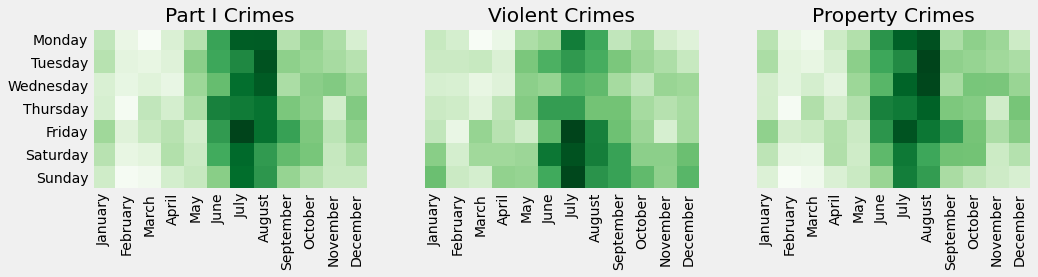

In [97]:
#, gridspec_kw={'hspace': 0, 'wspace': 0})
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
              'August', 'September', 'October', 'November', 'December']    
weekdays = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

plt.style.use('fivethirtyeight')

fig = plt.figure(figsize = (15,5))

#plt.yticks(range(21), weekdays*3)
#plt.xticks(range(12), months, rotation=90)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

#plt.grid(False) 
#plt.set_xticklabels(range(12), months, rotation="vertical")

#fig.suptitle("Fig. 3 - Most serious crimes", fontsize=30) 

#plt.label_outer()
#plt.set_xticks(range(12), weekdays)
for i in range(0,3):    
    #img = ax[idx//2][0]
    if i == 0:        
        df = getHeatmapArray(part_one_crimes)
        ax1.imshow(df,plt.cm.Greens,interpolation='nearest')
        ax1.set_title(titles[i])
        ax1.set_yticks(range(7))
        ax1.set_yticklabels(weekdays)
        ax1.set_xticks(range(12))
        ax1.set_xticklabels(months,rotation=90)
        ax1.grid(False)        
    elif i== 1:
        df = getHeatmapArray(violent_crimes)
        ax2.imshow(df,plt.cm.Greens,interpolation='nearest')
        ax2.set_title(titles[i])
        ax2.set_yticks([])
        #ax2.set_yticklabels(weekdays)
        ax2.set_xticks(range(12))
        ax2.set_xticklabels(months,rotation=90)
        ax2.grid(False)       
    else:
        df = getHeatmapArray(property_crimes)
        ax3.imshow(df,plt.cm.Greens,interpolation='nearest')
        ax3.set_title(titles[i])
        ax3.set_yticks([])
        #ax3.set_yticklabels(weekdays)
        ax3.set_xticks(range(12))
        ax3.set_xticklabels(months,rotation=90)
        ax3.grid(False)
    
    #title=title[idx] + " (" + str(int(np.sum(df))) + " obs.)"  
    #plt.title(title)
    #ax.set_xticklabels(months, rotation="vertical")
        
#fig.delaxes(ax[4,1])

<span class="caption"><strong>**Fig. 3. - Most serious crimes heatmaps.**</strong> At first glance, Black Friday sales for crime shopping occurs in July. Spot seven differences between the left heatmap and the right heatmap is certainly a tough game. Sorry, no prize for the winner!</span>

Part I crimes heatmap as well as property crimes heatmaps are like a reduced snapshot of the [Fig. 2](#fig2). Maybe this is the Holy Graal we were looking for: a peak in summer still showing up despite having strongly narrowed the data is a proof that the phenomena is strong enough to be sample reduction resistant. This is something for us. Does it mean that the most serious crimes are something -somewhere in the time or in the space- predictible? The way to reduce the crime has been factorized by [Lewitt (2004)](https://www.aeaweb.org/articles?id=10.1257/089533004773563485), it is a significant contribution though controversial. But wait, the empire of crime is a complex space -think a black hole with halo effect: easy to fall into, hard to quit, [stigma for life](https://phys.org/news/2016-08-stigma-criminal-individual-crime-conviction.html) like the Sisyphus rock regardless the extent of the criminal record- and [Minority Report emulators](https://projects.tampabay.com/projects/2020/investigations/police-pasco-sheriff-targeted/intelligence-led-policing/?fbclid=IwAR3b4nQWPc8-4gryIjtoa1pCx_KWj84taNAN7oTEixicFEr45L3-6L1rRYk) are incredibly naives, if not harmful for innocent people. We should **never** rely on outputs that could be life changing for an human being without first checking the inputs integrity... The fact is that more and more [studies](http://web.cs.ucla.edu/~kwchang/publications_area/#FEAT) are finding hidden bias in the data used during decades for training algorithms that finally are malicious enough to discretly [discriminates minorities](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing).

By contrast, the violent crimes heatmap is not converging so well toward a clear seasonal peak, as if spotting the crimes against persons was in fact the real challenge here. Maybe are we dealing with an obscured seasonal peak moving along the x-axis from year to year for some season hard to detect with a 2d plot. Better said, a shift of the seasonal peak location in time due, for example, to a very low violent crimes rate. This is the thesis developped by [Hipp *et al.*](https://academic.oup.com/sf/article-abstract/82/4/1333/1941990?redirectedFrom=fulltext) (not free) according to [Dong *et al.*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5609764/) (free). Since this is a well-known fact that [crime remains at historic lows in America](https://www.brennancenter.org/our-work/analysis-opinion/crime-remains-historic-lows-america) since now decades, the "shift in location" for robberies, for example, is a serious hypothesis to take in account. We will try to test this hypothesis later. Keeping in mind that the data does not always allow to answer our questions!

Aslo, a new interesting question is showing up: is Boston doing better or worst than expected compared to other American cities? I assume it's critical for the persons in charge at Boston -and also the citizens- to contribute to down even more the national downtrend while the curve is still far from hitting the "floor" after which it becomes difficult if not impossible to reduce the crime rate anymore. Since zero crime is obviously an "impossible horizon", this leads to a paradox: once reached very low levels of crime (proof of agents good work), it becomes harder to lower more the curve, and more likely to get bad results in the future (not a proof of agents bad work), losing therefore public funds. From this point of view, a public safety policy based only on quantified results is suboptimal and unfair to the agents, not to mention the fact that race for results ("get those numbers and come back with them") can lead to [serious misconducts](https://www.nytimes.com/2013/02/03/opinion/sunday/why-police-officers-lie-under-oath.html?pagewanted=all&_r=0).

In other words, how good -or bad- looks the long term crime trend in Boston, the birth city of the monumental Edgar Allan Poe alias ["jingle man"](https://www.nytimes.com/2014/10/05/us/edgar-allan-poes-feud-with-boston-nevermore.html)?

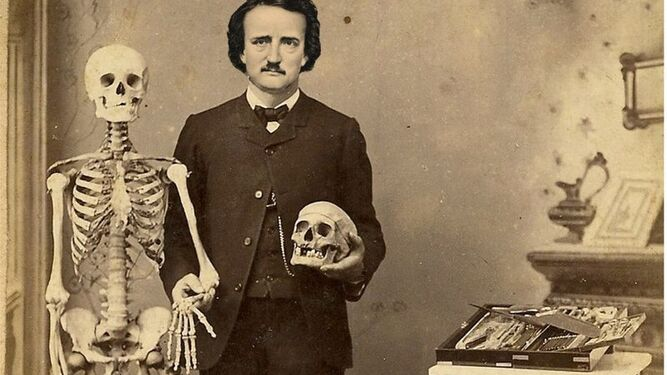
<figcaption>Edgar Allan Poe was dismissed as a "jingle man" by Emerson. But who remember Emerson? Time is a bitch.<figcaption>

That's a lot of questions now for a simple draft! With luck, we will be able to answer some of them in the next section. 

### Extracting crime trends and seasonality with Singular Spectrum Analysis (SSA)

This section is directly inspired from Dong *et al.* (already cited). We will try to reproduce some of their results, applying SSA to Boston data instead of LA and Houston. It's a pretty hard work, but we will progress step by step following the path exposed in the first part of the paper. The purpose is to extract long-term trends from noisy data.

See [Golyandina and Zhigljavsky (2013)](https://www.researchgate.net/publication/260124592_Singular_Spectrum_Analysis_for_Time_Series) for a complete description of the SSA procedure and this [Kaggle notebook](https://www.kaggle.com/jdarcy/introducing-ssa-for-time-series-decomposition) by [Joan d'Arcy](https://www.kaggle.com/jdarcy/notebooks) for Python implementation.



<s>Remember our [histogram](#histogram)? In the same way, the number of crimes in our dataset never exceeds 350 events on a single day over a three years period and vary in average by 90 (that is, since $\sigma\approx30$ and $\sigma = \sqrt {\mu }$). But the three-years trend is not falling in an inconsistent manner, well rather it is stable.</s>

#### Decomposition
##### The trajectory matrix 

The first step in the SSA involves mapping the data into lagged vectors creating a **trajectory matrix**.
The trajectory matrix is a sequence of $K$ *lagged vectors* of size $L$, such as $K = N - L + 1$ where $L$ is the window length (the long-term timeframe we want to extract) and $N$ the length of the time series.               

In [41]:
#creating a trajectory matrix
def createLaggedVectors(s, L):
    """
    inputs:
        s : series or 1d array-like
        L : an integer
        
    output: a 2d numpy array (Hankel matrix - all the elements along the diagonal are equal)
    """    
    N = len(s) 
    K = N - L + 1    
    X = np.zeros(shape=(L,K),dtype=np.float64)
    for i in range (0,L):
        for j in range(0,K):
            X[i][j]+= s[j+i]    
    return X

In [ ]:
X = createLaggedVectors(daily, 365)
print(X)
print(np.shape(X))

The lagged vectors $X_i$ $(1 \leq i \geq K)$ are the columns of the trajectory matrix $X$. Both, the rows
and columns of $X$ are subseries of the original series passed as parameter into createLaggedVectors().

##### Singular value decompositon (SVD) 

In [ ]:
from scipy.linalg import svd, diagsvd

In [ ]:
#performing the singular value decomposition (SVD) of the trajectory matrix with scipy
U, s, VT = svd(X)

According to [SciPy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html), SVD factorizes the trajectory matrix $X$ a into two unitary matrices $U$ and $VT$, and a 1-D array $s$ of singular values (real, non-negative) such that $X == U @ S @ VT$, where $S$ is a suitably shaped matrix of zeros with main diagonal $s$.

*Note about the operator $@$: when the matrix are 2-D this operator is preferred instead of $np.dot$.*

In [ ]:
print(np.shape(U)) #L x L orthogonal matrix containing the orthonormal set of left singular vectors of X as columns
print(np.shape(s)) #singular values of X, sorted in non-increasing order. Vector of shape (min(L, K),).
print(np.shape(VT))#K x K orthogonal matrix containing the orthonormal set of right singular vectors of X as columns

For the shake of clarity, let's take a moment to better understand [orthogonal matrix](https://www.sciencedirect.com/topics/mathematics/orthogonal-matrix).
A $n \times n$ orthogonal matrix $P$ have the following properties:

* Its columns are orthonormal $(1)$


* $P^TP = I_n <=> P^{-1} = P^T$ $(2)$


* $det(P) = \pm 1$ $(3)$

Matrix inverse, determinant and dot product are discussed in the [Dataquest course about Linear Algebra](https://www.dataquest.io/course/linear-algebra-for-machine-learning/).


In [ ]:
#checking for (1) (refer to https://www.sciencedirect.com/topics/mathematics/orthogonal-matrix)
tot = 0
for i in range(0,np.shape(U)[0]):
    dot_product = np.dot(U.T[i,:],U[:,i])
    tot+=np.sum(np.isclose(dot_product,1))
print(tot==np.shape(U)[0])
tot = 0
for i in range(0,np.shape(U)[0]):
    for j in range(0,np.shape(U)[0]):
        if i != j:
            dot_product = np.dot(U.T[i,:],U[:,j])
            tot+=np.sum(np.isclose(dot_product,1))
print(tot==0)
#checking for (2)
matrix_inverse = np.linalg.inv(U)
print(np.allclose(matrix_inverse,U.T))
#checking for (3) 
det = np.linalg.det(U)
print(np.isclose(det,[1,-1]))

We can construct the $L \times K$ diagonal matrix $S$ of zeros with main diagonal $s$ so that $X == U @ S @ VT$.

In [ ]:
#construct the sigma matrix from singular values s.


S = diagsvd(s,L,K)
print(np.shape(S))
print(np.allclose(X,U@S@VT))

Reconstruction
##### The elementary matrices

In [ ]:

TS_comps = np.zeros((N, L))
for i in range(0,365):
    #print(np.shape(U[:,i]))
    #print(np.shape(VT[:,i]))
    #U.dot(sigma.dot(VT))
    #Xi = S[i,:] * np.outer(U[:,i], VT[:,i])
    #365, 813
    
    #Xi = U[:,i].dot(S[i,:].dot(VT[:,i]))
    #print(np.shape(Xi))
    #TS_comps[:,i] = average_adiag(Xi)
    #product = np.array([s[i] * np.outer(U[:,i],VT[:,i])])
    #print(np.allclose(X,U@S@VT)))
    #print(np.shape(product))
    #print(product)
    #TS_comps+=product
    X_elem = s[i]*np.outer(U[:,i], VT[i,:])
    #X_elem2 = U[:,i].dot(s[i].dot(VT[i,:]))
    

##### Diagonal averaging

In [ ]:
X_rev = X_elem[::-1]
    TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]

In [ ]:
#np.allclose(daily,X[0])
print(np.allclose(daily,TS_comps.sum(axis=1)))
print(np.allclose(daily,average_adiag(X)))

In [ ]:
TS_comps[:,1]

In [ ]:
average_adiag(X)

In [ ]:
np.dot(U[:,0],np.dot(S[0,:],VT[0,:]))


In [ ]:
a=np.array([[2,3,4],[0,1],[1,7,6]])
a[::-1]


In [42]:
#let's put all pieces together in an unique function
def componentsExtractor(s,L):
    """
    inputs:
        s : series or 1d array-like
        L : an integer
        
    output: a 3d numpy array of shape (len(s) x L)
    """ 
    N = len(s)
    #trajectory matrix creation
    X = createLaggedVectors(s,L)
    #SVD decomposition
    U, s, VT = svd(X)
    #reconstruction
    X_components = np.zeros((N, L))
    for i in range(0,L):
        X_elem = s[i]*np.outer(U[:,i], VT[i,:])
        X_rev = X_elem[::-1]
        X_components[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
    return X_components

def aggregateBuilder(df):
    """
    inputs:
        df : a DataFrame time series     
       
    output: a daily aggregate pandas Series
    NS : use global list daily_index
    """
    #aggregate by day of the year and sort the index
    s = df.index.value_counts(sort=False).sort_index()
    #reindex with daily_index and fill the missing days with 0 as value
    s = s.reindex(daily_index, fill_value=0)
    return s

#### Plotting the components

We were asking above whether Boston is doing well or not. We can now answer the question extracting the long term trend for the UCR Part 1 crimes.
* The long term trend is the first mode in the SSA decomposition (those with the largest singular value, in other words the first column of the SSA matrix)
* We then sum the other first columns with annual periodicity to produce the seasonal component.

In [47]:
#daily_ssa = componentsExtractor(daily, 365)
part_one_crimes_aggregate = aggregateBuilder(part_one_crimes)
part_one_crimes_ssa = componentsExtractor(part_one_crimes_aggregate, 365)
violent_crimes_aggregate = aggregateBuilder(violent_crimes)
violent_crimes_ssa = componentsExtractor(violent_crimes_aggregate, 365)
property_crimes_aggregate = aggregateBuilder(property_crimes)
property_crimes_ssa = componentsExtractor(property_crimes_aggregate, 365)

#separate trend component from seasonal component
part_one_crimes_trend = pd.Series(part_one_crimes_ssa[:,0],daily_index)
part_one_crimes_seasonal = pd.Series(part_one_crimes_ssa[:,0:3].sum(axis=1),daily_index)
violent_crimes_trend = pd.Series(violent_crimes_ssa[:,0],daily_index)
violent_crimes_seasonal = pd.Series(violent_crimes_ssa[:,0:3].sum(axis=1),daily_index)
property_crimes_trend = pd.Series(property_crimes_ssa[:,0],daily_index)
property_crimes_seasonal = pd.Series(property_crimes_ssa[:,0:3].sum(axis=1),daily_index)

In [ ]:
<a id="fig4"></a>

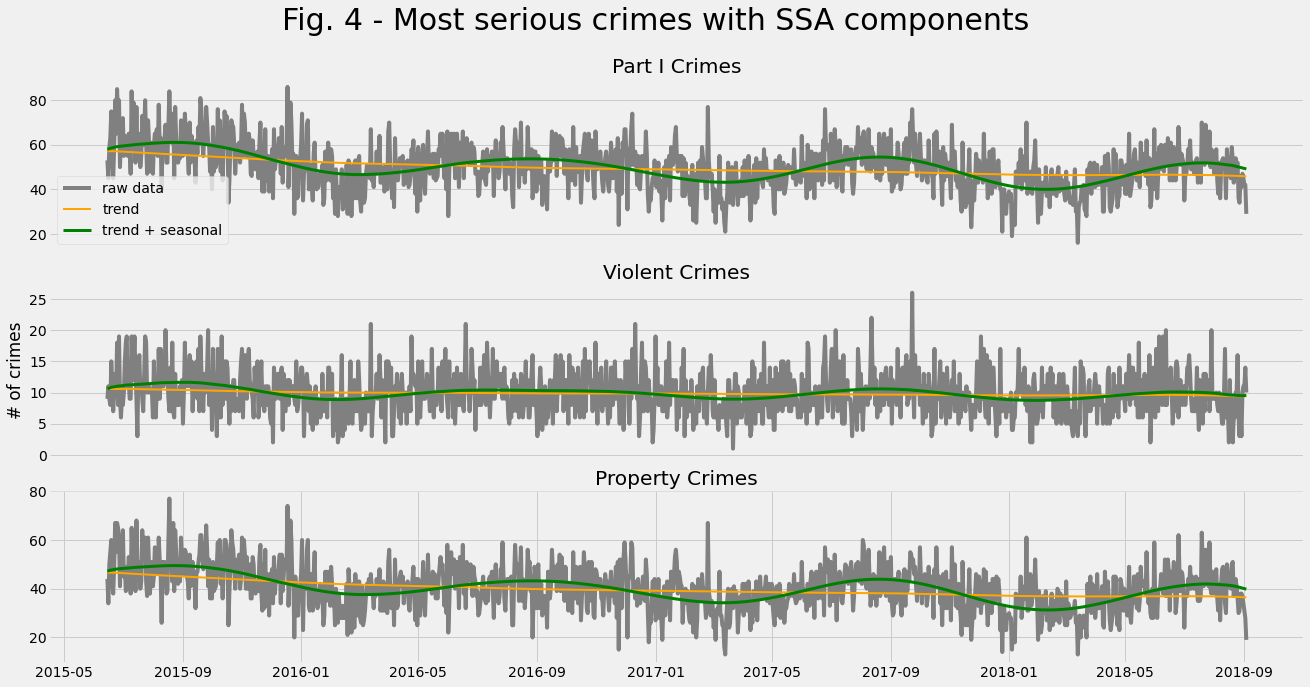

In [92]:

# plt.figure(figsize=(14,6))
# plt.plot(part_one_crimes_aggregate,color="grey",label="raw data")
# plt.plot(part_one_crimes_trend,color="orange",linewidth=2, label="trend")
# plt.plot(part_one_crimes_seasonal ,color="green",linewidth=3,label="trend + seasonal")

# plt.title("UCR Part I crimes")
# plt.legend()
# plt.ylabel("# daily events")
# plt.show()

fig = plt.figure(figsize = (20,10))


#plt.yticks(range(21), weekdays*3)
#plt.xticks(range(12), months, rotation=90)
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

#fig.suptitle("Fig. 4 - Most serious crimes with SSA components",fontsize=30)



#plt.grid(False) 
#plt.set_xticklabels(range(12), months, rotation="vertical")

#plt.label_outer()
#plt.set_xticks(range(12), weekdays)
for i in range(0,3):    
    #img = ax[idx//2][0]
    if i == 0:        
        ax1.plot(part_one_crimes_aggregate,color="grey",label="raw data")
        ax1.plot(part_one_crimes_trend,color="orange",linewidth=2, label="trend")
        ax1.plot(part_one_crimes_seasonal ,color="green",linewidth=3,label="trend + seasonal")
        ax1.set_title(titles[i])
        ax1.set_xticks([])
        #ax1.set_ylabel("# crimes")
        ax1.legend()        
          
    elif i== 1:        
        ax2.plot(violent_crimes_aggregate,color="grey",label="raw data")
        ax2.plot(violent_crimes_trend,color="orange",linewidth=2, label="trend")
        ax2.plot(violent_crimes_seasonal ,color="green",linewidth=3,label="trend + seasonal")
        ax2.set_title(titles[i])
        ax2.set_xticks([])
        ax2.set_ylabel("# of crimes")
    else:        
        ax3.plot(property_crimes_aggregate,color="grey",label="raw data")
        ax3.plot(property_crimes_trend,color="orange",linewidth=2, label="trend")
        ax3.plot(property_crimes_seasonal ,color="green",linewidth=3,label="trend + seasonal")
        ax3.set_title(titles[i])
        #ax3.set_ylabel("# crimes")
#txt="Blalalalalalal\nblablablablz"
#fig.text(-0.1,-0.1, txt, ha='left', wrap=True)

<span class="caption"><strong>Fig. 4 - Most serious crimes with SSA components.</strong> Daily aggregates are plotted in grey, long term trends in yellow, and the green curves are the long term trends plus the first two seasonal components.</span>

The number of UCR part I crimes in Boston is slowly falling accordingly to the national tendancy, but this is due to a sharp decline in property crimes frenquency, while violent crimes long term trend is flat as a hell ([Fig. 4)](#fig4). Note that the seasonal component for the last has a very low amplitude, almost impossible to detect without the SSA technique. We will know emphasize both violent crimes and property crimes long trends by zooming on their respective subcategories.

In [ ]:
#this for select the best seasonal components
#plt.xticks(range(12), months, rotation=90)
for idx, offense in enumerate(offenses_list):
    plt.figure(figsize=(10,5))
    daily_offense = offenseExtractor(data,offense).index.value_counts(sort=False).sort_index().reindex(daily_index, fill_value=0)
    ssa = componentsExtractor(daily_offense, 365)[:,1:5]
    for p in range(1,5):
        seasonal = pd.Series(ssa[:,p-1], index=daily_index)
    #normalize the values 
    #s = (1+trend.pct_change()).cumprod().fillna(1)      
        label=str(p)
        plt.plot(seasonal, label=label)
    plt.title(offense)
    plt.legend()
    plt.grid()   
    plt.show()

In [59]:
violent_crimes_list = ['ASSAULT - AGGRAVATED', 'MURDER', 'ROBBERY']
property_crimes_list = ['LARCENY', 'AUTO THEFT', 'ARSON', 'BURGLARY']

In [ ]:
<a id="fig5"></a>

<Figure size 432x288 with 0 Axes>

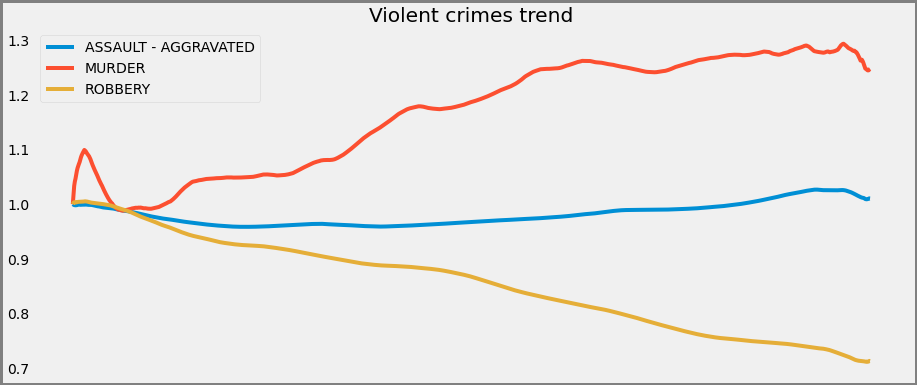

<Figure size 432x288 with 0 Axes>

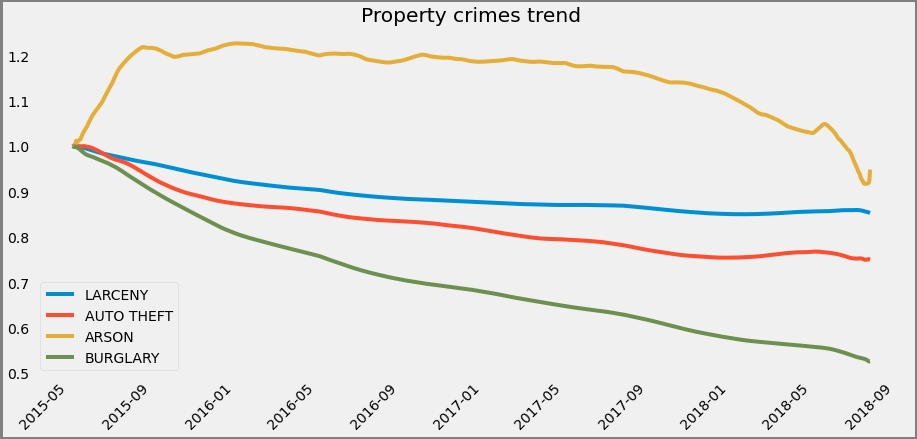

In [76]:
#plt.figure(figsize=(14,6))
#fig, ax = plt.subplots(2,1,  figsize=(10,5))

#plt.xticks(range(12), months, rotation=90)
for i in range(0,2):
    plt.suptitle("Fig. 5 - Long term trends by subcategories", fontsize=30)
    plt.figure(figsize=(14,6))
    if i == 0:
        
        off_list = violent_crimes_list     
    else: 
        off_list = property_crimes_list      
         
    for idx, offense in enumerate(off_list):
        daily_offense_aggregate = aggregateBuilder(offenseExtractor(data,offense))
        ssa = componentsExtractor(daily_offense_aggregate, 365)[:,0]

        trend = pd.Series(ssa, index=daily_index) 
        #normalize the values 
        s = (1+trend.pct_change()).cumprod().fillna(1) 

        plt.plot(s)
    if i == 0:
        plt.xticks([])
        title="Violent crimes trend"
    else:
        plt.xticks(rotation=45)
        title="Property crimes trend"
        
    plt.title(title)
    plt.legend(off_list)
    plt.grid(False)
    plt.show()

<span class="caption"><strong>Fig. 5 - Long term trends by subcategories.</strong> Following Dong <em>et al.</em> (2017) technique, the data has been normalized "to be the fraction of the initial crime level for the first time point $C_0$". The increasing murder long term trend may be scary at first glance, but keep in mind that murders occur very rarely (less than 1 homicide by day in average).</span>

That is, the top 2 categories are flying! The increasing of the first may just mean that police officers are looking for numbers, 
when the cat's away, the mice will play

In [ ]:
print(data['description'].value_counts()[0:5])
#let's check their relative weight
data['description'].value_counts()[0:5].cumsum()/data['description'].value_counts().sum()

In [ ]:
top_five_list = ['INVESTIGATE PERSON','SICK/INJURED/MEDICAL - PERSON','VANDALISM',
                 'M/V - LEAVING SCENE - PROPERTY DAMAGE','ASSAULT SIMPLE - BATTERY']
plt.figure(figsize=(14,6))
#plt.xticks(range(12), months, rotation=90)
for idx, offense in enumerate(top_five_list):
    daily_offense = offenseExtractor(data,offense).index.value_counts(sort=False).sort_index().reindex(daily_index, fill_value=0)
    ssa = componentsExtractor(daily_offense, 365)[:,0]
    trend = pd.Series(ssa, index=daily_index) 
    #normalize the values 
    s = (1+trend.pct_change()).cumprod().fillna(1) 
    
    plt.plot(s)

plt.title("Long term crime trends for the Top-5 offense types in terms of weight")
plt.legend(top_five_list)
#plt.grid()   
plt.show();

In [ ]:
#we will remove MURDER and ARSON from the study
revised_part_one = ['ASSAULT - AGGRAVATED', 'LARCENY', 'BURGLARY', 'ROBBERY', 'AUTO THEFT']

fig = plt.figure(figsize = (15,10))

#plt.yticks(range(21), weekdays*3)
#plt.xticks(range(12), months, rotation=90)
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)


plt.xticks(rotation=45)

#plt.grid(False) 
#plt.set_xticklabels(range(12), months, rotation="vertical")

#plt.label_outer()
#plt.set_xticks(range(12), weekdays)
for i in range(0,5):    
    #img = ax[idx//2][0]
    daily_offenses = aggregateBuilder(offenseExtractor(data,revised_part_one[i]))
    title = revised_part_one[i]
    if i<3:
        n=2        
    else:
        n=4
    ssa = componentsExtractor(daily_offenses, 365)[:,:n+1]
    seasonal, trend = pd.Series(ssa[:,1:n+1].sum(axis=1), index=daily_index), pd.Series(ssa[:,0], index=daily_index)
    smoothed_daily_offenses = (daily_offenses-trend).rolling(30,min_periods=1,center=True).mean() / trend
    seasonal = seasonal/trend    
    if i== 0:
        ax1.plot(smoothed_daily_offenses, label="Raw data")
        ax1.plot(seasonal, label="Seasonal component",color='orange')
        ax1.set_title(title)       
        ax1.set_xticks([])
        ax1.grid(False)
        ax1.legend()
        #ax1_set_legend()
    elif i== 1: 
        ax2.plot(smoothed_daily_offenses, label="Raw data")
        ax2.plot(seasonal, label="Seasonal component",color='orange')
        ax2.set_title(title)       
        ax2.set_xticks([])
        ax2.grid(False)
    elif i == 2:
        ax3.plot(smoothed_daily_offenses, label="Raw data")
        ax3.plot(seasonal, label="Seasonal component",color='orange')
        ax3.set_title(title)       
        ax3.set_xticks([])
        ax3.grid(False)
    elif i == 3:
        ax4.plot(smoothed_daily_offenses, label="Raw data")
        ax4.plot(seasonal, label="Seasonal component",color='orange')
        ax4.set_title(title)       
        #ax4.set_xticklabels(rotation = 45)
        ax4.grid(False)
    else:
        ax5.plot(smoothed_daily_offenses, label="Raw data")
        ax5.plot(seasonal, label="Seasonal component",color='orange')
        ax5.set_title(title)       
        #ax5.set_xticklabels(rotation = 45)
        ax5.grid(False)
    

#plt.show()
        

In [ ]:
#we will remove MURDER and ARSON from the study
revised_part_one = ['ASSAULT - AGGRAVATED', 'LARCENY', 'BURGLARY', 'ROBBERY', 'AUTO THEFT']

#plt.xticks(range(12), months, rotation=90)
for idx, offense in enumerate(revised_part_one):
    plt.figure(figsize=(10,5))
    daily_offenses = aggregateBuilder(offenseExtractor(data,offense))    
    if idx<3:
        n=2
    else:
        n=4
    ssa = componentsExtractor(daily_offenses, 365)[:,:n+1]
    seasonal, trend = pd.Series(ssa[:,1:n+1].sum(axis=1), index=daily_index), pd.Series(ssa[:,0], index=daily_index)
    
    #daily_offense = daily_offense / trend
    
       
    smoothed_daily_offenses = (daily_offenses-trend).rolling(30,min_periods=1,center=True).mean() / trend
    plt.plot(smoothed_daily_offenses, label="Raw data")
    plt.plot(seasonal/trend, label="Seasonal component",color='orange')
    if idx < 4:
        plt.xticks([])
    else:
        plt.xticks(rotation = 45)
    if idx == 0:
        plt.legend()
    plt.title(offense)   
       
    plt.show()

In [ ]:
trend = pd.Series(TS_comps[:,0],daily_index)
seasonal = pd.Series(TS_comps[:,0:3].sum(axis=1),daily_index)
plt.figure(figsize=(14,6))
plt.plot(trend,color="red",linewidth=3)
plt.plot(seasonal,color="green",linewidth=5)
plt.plot(daily,color="grey")
#plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(10,5))


seasonal, trend = pd.Series(TS_comps[:,1], index=daily_index), pd.Series(TS_comps[:,0], index=daily_index)

#daily_offense = daily_offense / trend


smoothed_daily = (daily-trend).rolling(30,min_periods=1,center=True).mean() / trend
plt.plot(smoothed_daily, label="Raw data")
plt.plot(seasonal/trend, label="Seasonal component")
plt.title("Daily")
plt.legend()
plt.grid()   
plt.show()

In [ ]:
_str=""
for idx, i in enumerate(revised_ucr_part_one):
    if idx < (len(revised_ucr_part_one)-1):
        _str+=i+"|"
    else:
        _str+=i
merged_ucr = offenseExtractor(data,_str).index.value_counts(sort=False).sort_index().reindex(daily_index, fill_value=0)

In [ ]:
merged = componentsExtractor(merged_ucr, 365)

trend = pd.Series(merged[:,0],daily_index)
seasonal = pd.Series(merged[:,0:3].sum(axis=1),daily_index)
plt.figure(figsize=(14,6))
plt.plot(trend,color="red",linewidth=3)
plt.plot(seasonal,color="green",linewidth=5)
plt.plot(merged_ucr,color="grey")
#plt.grid()
plt.show()

This is a example of footnote[<sup>1</sup>](#fn1). And this is another footnote[<sup>2</sup>](#fn2).

<span id="fn1"> Your footnote 1 here.</span>
<span id="fn2"> Your footnote 2 here.</span>

def f(x):
    """a docstring"""
    return x**2

In [ ]:
a, b, c = np.linalg.svd(X)
print(np.allclose(X,np.dot(a * b, c)))

In [ ]:
#reconstruction
B = U.dot(sigma.dot(VT))
print(np.shape(B))
B

In [ ]:
def average_adiag(x):
    """Average antidiagonal elements of a 2d array
    Parameters:
    -----------
    x : np.array
        2d numpy array of size

    Return:
    -------
    x1d : np.array
        1d numpy array representing averaged antediangonal elements of x

    """
    x1d = [np.mean(x[::-1, :].diagonal(i)) for i in
           range(-x.shape[0] + 1, x.shape[1])]
    return np.array(x1d)

In [ ]:
#averaging over the antidiagonals i+j
avg = average_adiag(S)
print(np.shape(avg))
avg

In [ ]:
np.sum(s)

In [ ]:
import datetime
daily.index = pd.to_datetime(daily.index)
day = daily.groupby(daily.index.day).sum() 
month = daily.groupby(daily.index.month).sum()
year = daily.groupby(daily.index.year).sum()
cross_table = np.zeros(shape=(7,12),dtype=np.float32)
for i in range(len(data)):
    d=data.index[i].weekday()
    m=data.index[i].month
    cross_table[d][m-1]+=1


In [ ]:
#cross_table=np.divide(cross_table,np.sum(cross_table,axis=0))
#sum each columns
np.sum(cross_table,axis=0)

In [ ]:
daily.groupby(daily.index.month).sum()

In [ ]:
np.sum(datas['description'].value_counts().cumsum()/len(datas)<0.8)

In [ ]:
datas['description'].value_counts()[0:37]

In [ ]:
plt.plot(np.sum(cross_table,axis=0))

In [ ]:
plt.scatter(datas['long'],datas['lat'])
plt.show()

In [ ]:
dt=datas['description'].value_counts()

In [ ]:
dt.describe()

In [ ]:
plt.hist(dt)

In [ ]:
drugs_crime = list()
for i in dt.index:
    if i[0:5] =="DRUGS":
        drugs_crime.append(i)

In [ ]:
 drugs_crime

In [ ]:
dt[0:30].sum()

In [ ]:
inj = datas[datas['description']=="DRUGS - SICK ASSIST - HEROIN"]

In [ ]:
plt.scatter(inj['long'],inj['lat'],cmap=cm.hsv)
plt.show()

In [ ]:
plt.hist(datas['long'])

In [ ]:
plt.hist(inj['long'])

In [ ]:
plt.hist(inj['lat'])

In [ ]:
from scipy.stats import gaussian_kde
# Calculate the point density
xy = np.vstack([inj['long'],inj['lat']])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(inj['long'], inj['lat'], c=z, s=100, edgecolor='')
plt.show()

In [ ]:
fig = sns.jointplot(x='long', y='lat', data=inj, kind='kde', cmap='Reds', color='red')
plt.show()

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(4,2, figsize=(10, 15), sharex=True, sharey=True)

_name = 'DRUGS'
qb = datas.loc[(datas['description'].str.contains(_name))]
sns.kdeplot(qb.long, qb.lat, ax=ax[0,0], cmap='Reds').set_title(_name)


_name = 'CLASS A'
qb = datas.loc[(datas['description'].str.contains(_name))]
sns.kdeplot(qb.long, qb.lat, ax=ax[0,1], cmap='Reds').set_title(_name)

#SUICIDE
#DEATH
#MEDICAL
#SICK ASSIST
#ASSAULT - AGGRAVATED
#MURDER
#ROBBERY
#AUTO THEFT
#LARCENY
#BURGLARY

_name = 'CLASS B'
qb = datas.loc[(datas['description'].str.contains(_name))]
sns.kdeplot(qb.long, qb.lat, ax=ax[1,0], cmap='Reds').set_title(_name)


_name = 'CLASS C'
qb = datas.loc[(datas['description'].str.contains(_name))]
sns.kdeplot(qb.long, qb.lat, ax=ax[1,1], cmap='Reds').set_title(_name)


_name = 'CLASS D'
qb = datas.loc[(datas['description'].str.contains(_name))]
sns.kdeplot(qb.long, qb.lat, ax=ax[2,0], cmap='Reds').set_title(_name)


_name = 'MEDICAL'
qb = datas.loc[(datas['description'].str.contains(_name))]
sns.kdeplot(qb.long, qb.lat, ax=ax[2,1], cmap='Reds').set_title(_name)


_name = 'DRUGS - SICK ASSIST - HEROIN'
qb = datas.loc[(datas['description'].str.contains(_name))]
sns.kdeplot(qb.long, qb.lat, ax=ax[3,0], cmap='Reds').set_title(_name)


_name = 'SICK ASSIST'
qb = datas.loc[(datas['description'].str.contains(_name))]
sns.kdeplot(qb.long, qb.lat, ax=ax[3,1], cmap='Reds').set_title(_name)

plt.show()


In [ ]:
inj2 = datas[datas['description']=="DRUGS - SICK ASSIST - OTHER NARCOTIC"]
xy = np.vstack([inj2['long'],inj2['lat']])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(inj2['long'], inj2['lat'], c=z, s=100, edgecolor='')
plt.show()

In [ ]:
inj3 = datas[datas['description']=="DRUGS - SICK ASSIST - OTHER HARMFUL DRUG"]
xy = np.vstack([inj3['long'],inj3['lat']])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(inj3['long'], inj3['lat'], c=z, s=100, edgecolor='')
plt.show()

In [ ]:
inj4 = datas[datas['description']=="DRUGS - SALE / MANUFACTURING"]
xy = np.vstack([inj4['long'],inj4['lat']])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(inj4['long'], inj4['lat'], c=z, s=100, edgecolor='')
plt.show()

In [ ]:
l=len(inj['date'].value_counts())
d = inj['date'].value_counts().sort_index()
plt.plot(d)

In [ ]:
inj['date'].value_counts().sort_index()

In [ ]:
plt.plot(range(0,len(datas['date'].value_counts())),datas['date'].value_counts())
plt.show()

In [ ]:
l=len(datas['date'].value_counts())


In [ ]:
d = datas['date'].value_counts().sort_index()
plt.plot(range(0,l),d)

In [ ]:
d.hist()

In [ ]:
import pymc3 as pm
import theano.tensor as tt

In [ ]:
jupyter --paths

In [ ]:
from pygments.styles import get_all_styles
from pygments.formatters import Terminal256Formatter
from pygments.lexers import PythonLexer
from pygments import highlight

code = """
import os
def function(test=1):
    if test in [3,4]:
      print(test)
"""
for style in get_all_styles():
    highlighted_code = highlight(code, PythonLexer(), Terminal256Formatter(style=style))
    print(f"{style}:\n{highlighted_code}")

In [ ]:
import sys  
sys.path.insert(0, '/C:\Users\Wilfrid\Documents\GitHub\jupyter_web')

import render.py